# Solar-System-Problem:   Energy conservation

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Solar-System-Problem">
             Initial value problem: Solar-System-Problem</a></li>

<li><a href="#Energy errors">
             Energy-errors</a></li>
             
<li><a href="#Save/Load Data">
             Save/Load-Data</a></li> 
             
<li><a href="#Plot for Juliacon2020">
            Plot-for-Juliacon2020</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq
using DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates,LaTeXStrings
using JLD2, FileIO

<a href="#top">Back to the top</a>

## Computer properties

In [ ]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

In [4]:
#;cat /proc/cpuinfo # on Linux machines

In [ ]:
using Hwloc
Hwloc.num_physical_cores()

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System-Problem

In [2]:
setprecision(BigFloat, 108);
include("../examples/Nbody.jl")
include("../examples/InitialNBody9.jl")

dt=6
t0=0.0
t1=10^6


u064,Gm64 =InitialNBody9(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialNBody9(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mysaveat=1000
vsaveat=100.;

(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64,3}, Array{Float64,1}, Tuple{Float64,Int64}, Array{BigFloat,3}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Energy errors

In [3]:
setprecision(BigFloat, 256)

u0256,Gm256=InitialNBody9(BigFloat)

E0=NbodyEnergy(u0256,Gm256)


-9.831951850714509861613682908577622008275351805284600444356653442764997668898217e-12

### Numerical integrations

In [8]:
sol1= solve(probdyn64,IRKGL16(),adaptive=false, mixed_precision=false, dt=6,saveat=mysaveat)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  7977294
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          166667
Number of rejected steps:                          0

In [9]:
sol2= solve(probdyn64,IRKGL16(),adaptive=false, mixed_precision=true, dt=6, saveat=mysaveat)
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  7977294
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          166667
Number of rejected steps:                          0

In [10]:
sol11 =solve(probdyn64,Vern9(), abstol=1e-13,reltol=1e-13) #saveat=vsaveat)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  9994450
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          510976
Number of rejected steps:                          113677

In [11]:
sol21= solve(prob2nd64,DPRKN12(),abstol=1e-13,reltol=1e-13) #saveat=vsaveat)
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  3865089
Number of function 2 evaluations:                  227359
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          204623
Number of rejected steps:                          22735

In [12]:
k=1000
ΔE1 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol2.u)./E0.-1
ΔE11 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol11.u[1:k:end])./E0.-1
ΔE21 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol21.u[1:k:end])./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE11))), Float32(maximum(abs.(ΔE21))))

(6.3564317f-16, 6.3564317f-16, 6.9313083f-13, 8.4896425f-14)

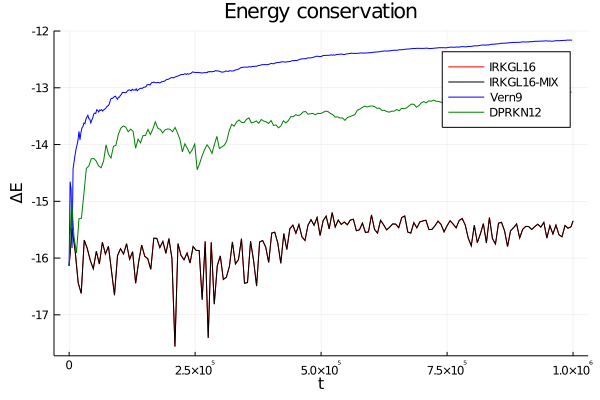

In [13]:
plot(title="Energy conservation", xlabel="t", ylabel="ΔE")
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16", color="red")
plot!(sol2.t,log10.(abs.(ΔE2)), label="IRKGL16-MIX", color="black")
plot!(sol11.t[1:k:end],log10.(abs.(ΔE11)), label="Vern9", color="blue")
plot!(sol21.t[1:k:end],log10.(abs.(ΔE21)), label="DPRKN12", color="green")

<a href="#top">Back to the top</a>

## Save/Load Data

In [15]:
#save("./Data/output/OutN9BodyEnergy.jld2", "ΔE1", ΔE1, "ΔE2", ΔE2, "ΔE11", ΔE11, "ΔE21", ΔE21,     
#                                     "sol1t", sol1.t, "sol2t", sol2.t,
#                                      "sol11t", sol11.t[1:k:end], "sol21t", sol21.t[1:k:end])

## Plot for Juliacon2020

In [4]:
sol1t=load("./Data/output/OutN9BodyEnergy.jld2", "sol1t")
ΔE1=load("./Data/output/OutN9BodyEnergy.jld2", "ΔE1")
sol21t=load("./Data/output/OutN9BodyEnergy.jld2", "sol21t")
ΔE21=load("./Data/output/OutN9BodyEnergy.jld2", "ΔE21");

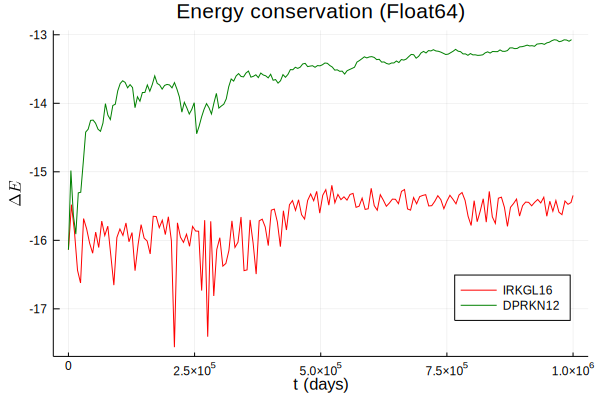

In [5]:
plot(title="Energy conservation (Float64)", xlabel="t (days)", ylabel=L"\Delta E",size= (600,400))    
plot!(sol1t,log10.(abs.(ΔE1)), label="IRKGL16", color="red",legend=:bottomright)
plot!(sol21t,log10.(abs.(ΔE21)), label="DPRKN12", color="green")

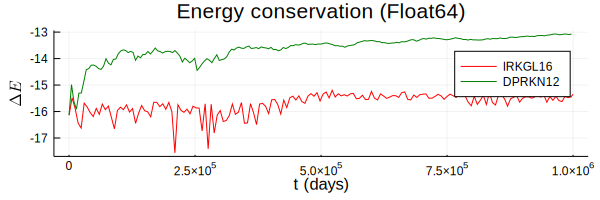

In [6]:
plot(title="Energy conservation (Float64)", xlabel="t (days)", ylabel=L"\Delta E",size= (600,200))    
plot!(sol1t,log10.(abs.(ΔE1)), label="IRKGL16", color="red")
plot!(sol21t,log10.(abs.(ΔE21)), label="DPRKN12", color="green")